# Still missing stuff:
* CNN is not yet implemented
* Chris Mathy's favorite performance metric is not used
* *Please add other things on this "to do list" that are missing*

# Loading packages

In [28]:
import cv2
import numpy as np
import pandas as pd
import keras
from keras import layers
from keras.utils import np_utils
from scipy.signal import medfilt
from keras.datasets import mnist
from sklearn import svm, metrics, datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
digits = datasets.load_digits()

# Defining functions

## Binarize images

In [3]:
# Define function for making binary
def make_binary(img, threshold):

    img[img >= threshold] = 255
    img[img < threshold] = 0
    
    return img

## GoL image processing

In [4]:
# Define function for Game of Life
def GoL(seed, n_generations):
    # Empty list for appending generations to (and start with the seed)
    generations = []
    
    # Append seed to list of generations
    generations.append(seed)
    
    # Apply 1-layer 0-padding
    seed = np.pad(seed, 1)

    # Define n_rows and n_cols from shape of img
    n_rows, n_cols = seed.shape

    # Perform ticks
    for i in range(n_generations):
        # Create image for next step, for overwriting
        generation = np.array(np.zeros(shape=(n_rows, n_cols), dtype=np.int32))
        
        # For loop that iterates over each cell in the array
        for r in range(n_rows-2):
            for c in range(n_cols-2):
                
                # seed[r+1, c+1] (the "middle" cell during each window) and sum_context (sum of all cells around "middle" cell in window) ...
                # ... has the right information. Check with: print(seed[r+1, c+1]) and print(sum_context)
                sum_context = seed[r, c] + seed[r, c+1] + seed[r, c+2] + seed[r+1, c] + seed[r+1, c+2] + seed[r+2, c] + seed[r+2, c+1] + seed[r+2, c+2]

                # Any live cell with fewer than 2 or more than 3, dies
                if seed[r+1, c+1] == 1*255:
                    if sum_context < 2*255 or sum_context > 3*255:
                        generation[r+1, c+1] = 0
                
                # Any live cell with two or three live neighbours lives, unchanged
                if seed[r+1, c+1] == 1*255 and 4*255 > sum_context > 1*255:
                    generation[r+1, c+1] = 1*255

                # Any dead cell with exactly 3 three live neighbours will come to life
                if seed[r+1, c+1] == 0 and sum_context == 3*255:
                    generation[r+1, c+1] = 1*255
        
        # Assign newest generation as the new seed
        seed = generation.copy()

        # Append newest generation to list of generations 
        generations.append(generation[1:-1, 1:-1])
    
    return generations

## Test functions

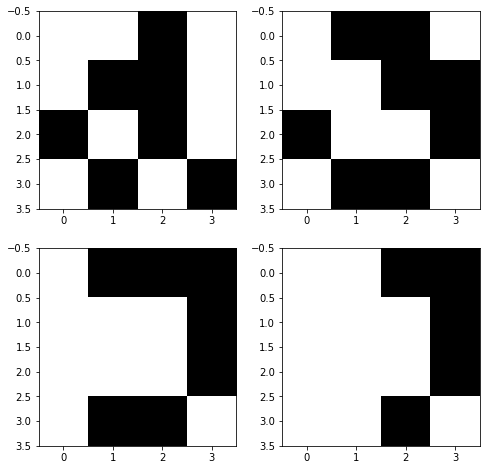

In [5]:
# Set arbitrary seed
seed = np.array([[124, 34, 126, 0], [0, 255, 255, 74], [255, 0, 255, 0], [0, 170, 0, 178]])

# Binarize with threshold = 125
seed = make_binary(seed, 125)

# Perform 7 steps of GoL
generations = GoL(seed, 3)

# Plot generations
fig = plt.figure(figsize=(8, 8))
columns = len(generations)//2
rows = len(generations)//2
for i in range(1, len(generations)+1):
    generations[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(generations[i-1], cmap="gray_r")
plt.show()

# MNIST
* Load MNIST
* Binarize MNIST
* Perform steps of GoL on MNIST
* *Perform steps of other cellular automata*
* Show example of MNIST after GoL
* *Show example of MNIST after other cellular automata*

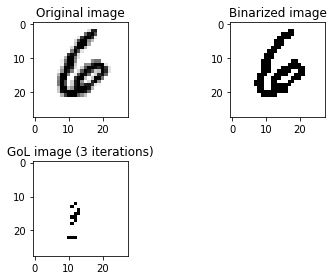

In [16]:
# Load data
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# Concatenate so that we may add validation set also
X = np.concatenate((train_X, test_X), axis=0)
y = np.concatenate((train_y, test_y), axis=0)

# Subset for faster processing
X = X[:1000]
y = y[:1000]

# Binarize MNIST (X, not y)
X_bina = [make_binary(np.array(img.copy(), dtype=np.int32), 125) for img in X]

# Perform GoL on MNIST
X_GoL = [GoL(img, 3)[-1] for img in X_bina]

# Perform ___ on MNIST ...

# Perform ___ on MNIST ...

# Perform ___ on MNIST ...

X_sets = [X, X_bina, X_GoL] # Add the other image processing types to this list
X_sets_names = ["X", "X_bina", "X_GoL"] # Add the other image processing types to this list

# Plot
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(X[13], cmap='gray_r')
ax1.title.set_text('Original image')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(X_bina[13], cmap="gray_r")
ax2.title.set_text('Binarized image')
ax3 = fig.add_subplot(2,2,3)
ax3.title.set_text('GoL image (3 iterations)')
ax3.imshow(X_GoL[13], cmap="gray_r")
plt.tight_layout()

# Machine learning

## LR, SVM and CNN

In [100]:
# CNN model specifications
batch_size = 128
epochs = 15
input_shape = (28, 28, 1)
num_classes = len(set(y)) # Define number of classes
cnn = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

# Lists for appending each confusion matrix and classification report
lr_cm = []
lr_cr = []

svm_cm = []
svm_cr = []

cnn_cm = []
cnn_cr = []

# Loop for fitting and validating
for X in X_sets:
    
    # Split into train test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .10, random_state=42)

    # Flatten all 2D-arrays to 1D for LR and SVM
    X_train_flat = [img.flatten() for img in X_train]
    X_test_flat = [img.flatten() for img in X_test]

    ############################################# Train + predict #############################################
    # Train and predict LR
    lr = LogisticRegression()
    lr.fit(X_train_flat, y_train)
    lr_predictions = lr.predict(X_test_flat)

    # Train and predict SVM
    clf = svm.SVC()
    clf.fit(X_train_flat, y_train)
    svm_predictions = clf.predict(X_test_flat)

    # Train and predict CNN
    X_train_cnn = np.expand_dims(X_train, -1) # Make sure each img has dimensions 28, 28, 1
    X_test_cnn = np.expand_dims(X_test, -1)
    y_train_cnn = keras.utils.np_utils.to_categorical(y_train, num_classes) # One-hot encoding of y 
    y_test_cnn = keras.utils.np_utils.to_categorical(y_test, num_classes)
    cnn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]) # Compile the model
    cnn.fit(X_train_cnn, y_train_cnn, epochs=epochs) # Fit the model
    cnn_predictions = cnn.predict(X_test_cnn) # Make predictions (outcome is in probabilites)
    cnn_predictions = [np.argmax(cnn_prediction) for cnn_prediction in cnn_predictions] # to go from list of probabilities [0.8, 0.143, 0.03, ...] to the index of the highest probability

    ############################################# Validate #############################################
    # Validate LR
    lr_cm.append(metrics.confusion_matrix(y_test, lr_predictions))
    lr_cr.append(pd.DataFrame.from_dict(metrics.classification_report(y_test, lr_predictions, output_dict=True)))

    # Validate LR
    svm_cm.append(metrics.confusion_matrix(y_test, svm_predictions))
    svm_cr.append(pd.DataFrame.from_dict(metrics.classification_report(y_test, svm_predictions, output_dict=True)))

    # Validate CNN
    cnn_cm.append(metrics.confusion_matrix(y_test, cnn_predictions))
    cnn_cr.append(pd.DataFrame.from_dict(metrics.classification_report(y_test, cnn_predictions, output_dict=True)))

# See performance for each X_set
for i in range(len(X_sets_names)):
    print(f"\n \n Evaluation statistics for logistic regression on the dataset with image processing {X_sets_names[i]}:")
    print(lr_cm[i])
    print(lr_cr[i])

    print(f"\n \n Evaluation statistics for SVM on the dataset with image processing {X_sets_names[i]}:")
    print(svm_cm[i])
    print(svm_cr[i])

    print(f"\n \n Evaluation statistics for CNN on the dataset with image processing {X_sets_names[i]}:")
    print(cnn_cm[i])
    print(cnn_cr[i])

c:\Users\Lenovo\miniconda3\envs\methods3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 1/15
29/29 [==============================] - 2s 30ms/step - loss: 18.3333 - accuracy: 0.3522
Epoch 2/15
29/29 [==============================] - 1s 30ms/step - loss: 2.0829 - accuracy: 0.7056
Epoch 3/15
29/29 [==============================] - 1s 30ms/step - loss: 1.2492 - accuracy: 0.7444
Epoch 4/15
29/29 [==============================] - 1s 27ms/step - loss: 0.6904 - accuracy: 0.8044
Epoch 5/15
29/29 [==============================] - 1s 29ms/step - loss: 0.6166 - accuracy: 0.8478
Epoch 6/15
29/29 [==============================] - 1s 32ms/step - loss: 0.4480 - accuracy: 0.8900
Epoch 7/15
29/29 [==============================] - 1s 27ms/step - loss: 0.4181 - accuracy: 0.8700
Epoch 8/15
29/29 [==============================] - 1s 28ms/step - loss: 0.3822 - accuracy: 0.8867
Epoch 9/15
29/29 [==============================] - 1s 28ms/step - loss: 0.3342 - accuracy: 0.8989
Epoch 10/15
29/29 [==============================] - 1s 29ms/step - loss: 0.2861 - accuracy: 0.9133
Epoch 11

c:\Users\Lenovo\miniconda3\envs\methods3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 1/15
29/29 [==============================] - 2s 28ms/step - loss: 0.4603 - accuracy: 0.8967
Epoch 2/15
29/29 [==============================] - 1s 29ms/step - loss: 0.3224 - accuracy: 0.9278
Epoch 3/15
29/29 [==============================] - 1s 28ms/step - loss: 0.2853 - accuracy: 0.9322
Epoch 4/15
29/29 [==============================] - 1s 29ms/step - loss: 0.2385 - accuracy: 0.9367
Epoch 5/15
29/29 [==============================] - 1s 30ms/step - loss: 0.2559 - accuracy: 0.9478
Epoch 6/15
29/29 [==============================] - 1s 29ms/step - loss: 0.1845 - accuracy: 0.9667
Epoch 7/15
29/29 [==============================] - 1s 30ms/step - loss: 0.1570 - accuracy: 0.9633
Epoch 8/15
29/29 [==============================] - 1s 27ms/step - loss: 0.1667 - accuracy: 0.9533
Epoch 9/15
29/29 [==============================] - 1s 28ms/step - loss: 0.1280 - accuracy: 0.9711
Epoch 10/15
29/29 [==============================] - 1s 29ms/step - loss: 0.1641 - accuracy: 0.9589
Epoch 11/

c:\Users\Lenovo\miniconda3\envs\methods3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 1/15
29/29 [==============================] - 1s 27ms/step - loss: 5.3006 - accuracy: 0.1689
Epoch 2/15
29/29 [==============================] - 1s 31ms/step - loss: 2.1473 - accuracy: 0.2544
Epoch 3/15
29/29 [==============================] - 1s 28ms/step - loss: 2.0056 - accuracy: 0.2956
Epoch 4/15
29/29 [==============================] - 1s 28ms/step - loss: 1.8581 - accuracy: 0.3656
Epoch 5/15
29/29 [==============================] - 1s 28ms/step - loss: 1.6830 - accuracy: 0.4233
Epoch 6/15
29/29 [==============================] - 1s 30ms/step - loss: 1.5528 - accuracy: 0.4567
Epoch 7/15
29/29 [==============================] - 1s 31ms/step - loss: 1.4552 - accuracy: 0.5056
Epoch 8/15
29/29 [==============================] - 1s 29ms/step - loss: 1.3576 - accuracy: 0.5444
Epoch 9/15
29/29 [==============================] - 1s 29ms/step - loss: 1.1901 - accuracy: 0.5767
Epoch 10/15
29/29 [==============================] - 1s 35ms/step - loss: 1.1397 - accuracy: 0.6344
Epoch 11/

# Extra stuff (potentially useful?)

In [ ]:
# Function for applying kernel any number of iterations with "basic" kernel
def iterated_kernel(img, kernel, iterations):
    
    for i in range(iterations):
        img = cv2.filter2D(img, -1, kernel)
    
    return img

# Test function
img_orig = np.array([[124, 125, 126, 0], [0, 255, 255, 0], [255, 0, 255, 0], [0, 0, 0, 0]])
img_bina = make_binary(img_orig.copy(), 125)

print(img_orig)
print(img_bina)

kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]])

cv2.filter2D(img_orig, -1, kernel)

# img_iterated_once = iterated_kernel(img_bina, kernel, 1)
# img_iterated_twice = iterated_kernel(img_bina, kernel, 2)

# Plotting different versions
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img_orig, cmap='gray_r')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(img_bina, cmap='gray_r')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(img_iterated_once, cmap='gray_r')
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(img_iterated_twice, cmap='gray_r')